### NAME COURSE
### Project:
### By: Alex (342569985) Romanovskii and Luiza (342569993) Romanovskii

Firstly import required packages

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

import json
import git
from git import Repo
import gensim
from gensim import corpora
from gensim import similarities
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer 
import jira
import pandas as pd
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import spacy
import pyLDAvis
import pyLDAvis.gensim 
import seaborn as sns
import matplotlib.pyplot as plt

# pd.options.display.max_colwidth = 500

### For study, data from two projects were used: LANG and WICKET.  
### Project LANG

Description of the commits we received from the github

In [3]:
# Repo.clone_from('https://github.com/TomMD/apache-commons-lang.git', 'Desktop/g')
# repo = git.Repo(r"C:\\Users\\User\\Desktop\\g\\.git")
# d = dict()
# for commit in repo.iter_commits():
#     d[commit.hexsha] = commit.message
# f = open(r"C:\\Users\\User\\Desktop\\commits_lang.json", "w",encoding="utf8")
# json.dump(d, f)
# f.close()

Now we have three path files:

**"path_commit_bag"** - path to file bag with description (received from Amir)   
**"path_commit_function"** - path to file commit with changed functions (received from Amir)   
**"path_commit"** - path to file commits with description  


In [3]:
path_commit_bug='LANG/lang_issues.json'
path_commit_function='LANG/lang_methods.json'
path_commit='LANG/commits_lang.json'

We want to write function that according to path files can to prepare files to topic modelling 

In [28]:
def preprocessing(path_commit_bug,path_commit_function,path_commit,project,verbose=False,head=10):
    if verbose==True:
        print('Step 1. We need to open all paths and to load them to DataFrmame')
    with open(path_commit_bug) as f:
        commit_bug = json.load(f)
    df_commit_bug=pd.DataFrame([(a,b) for i in commit_bug for a,b in i.items()],columns=['Commit','Bug_number'])
    if verbose==True:
        print('\nFile with commit/bug:')
        display(df_commit_bug.head(head))   
    with open(path_commit_function) as f:
        commit_function = json.load(f)
    commit = [k for k in commit_function.keys() for v in commit_function[k]]
    function = [v for k in commit_function.keys() for v in commit_function[k]]
    df_commit_func=pd.DataFrame.from_dict({'Commit': commit, 'Function': function})
    if verbose==True:
        print('\nFile with commit/functions:')
        display(df_commit_func.head(head)) 
    with open(path_commit) as f:
        commit = json.load(f)
    df_commit_desc=pd.DataFrame([[a,b] for a,b in commit.items()],columns=['Commit','Describe'])
    if verbose==True:
        print('\nFile with commit/describe:')
        display(df_commit_desc.head(head)) 
    df_commit_func_describe_bug=df_commit_bug.merge(df_commit_func, on='Commit').merge(df_commit_desc, on='Commit')
    if verbose==True:
        print('\nStep 2. Lets merge three dataframes in one')
        display(df_commit_func_describe_bug.head(head)) 
    def split_func(func):
        split=func.split('.')
        return '.'.join([split[-2],split[-1]])   
    def split_desc(func):
        return func.split('\n')[0]    
    
    df_commit_func_describe_bug['Function']=df_commit_func_describe_bug['Function'].apply(lambda x:split_func(x)) 
    df_commit_func_describe_bug['Describe']=df_commit_func_describe_bug['Describe'].apply(lambda x:split_desc(x)) 
    df_commit_func_describe_bug=df_commit_func_describe_bug[df_commit_func_describe_bug['Bug_number']!='0']
    if verbose==True:
        print('\nStep 3. Lets do small preprocessing to column "Function" and "Describe"')
        display(df_commit_func_describe_bug.head(head))
        print('\nNumber of unique functions: {}'.format(len(df_commit_func_describe_bug.Function.unique())))
        print('Number of unique bugs: {}'.format(len(df_commit_func_describe_bug.Bug_number.unique())))
    
    list_functions=df_commit_func_describe_bug['Function'].unique().tolist()
    dict_func_desc={}
    for function in list_functions:
        all_desription=set(df_commit_func_describe_bug['Describe'][df_commit_func_describe_bug['Function']==function].tolist())
        all_desription=' '.join(all_desription)
        dict_func_desc[function]=all_desription
    df_function_description=pd.DataFrame([(a,b) for a,b in dict_func_desc.items()],columns=['Function','Decription'])    
    if verbose==True:
        print('\nStep 4. Lets get a document describing each function')
        display(df_function_description.head(head))    
    
    def clean_str(string):
        en_stop = set(nltk.corpus.stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        ch=['%','=','\n','_','\r','.','$','/','!','?','*','(',')','{','}',';',',','<','>',"'","'",'"','"','[',']',':',';','&','#','-','?','@','+']
        for i in ch:
            string=string.replace(i,' ')
        new_string=string.split(' ') 
        new_new_string=[]
        for i in new_string:
            if len(re.findall(r'[A-Z][^A-Z]*', i))==0:
                new_new_string.append(i)
            else:
                new_new_string.extend(re.findall(r'[A-Z][^A-Z]*', i))
        new_new_string=[lemmatizer.lemmatize(i.lower().strip(),'v') for i in new_new_string if len(i)>1 and i.strip() not in en_stop and not i.isdigit()]    
        new_new_string=[i for i in new_new_string if i!='to']
        return new_new_string
    df_function_description['Description_clear']=df_function_description['Decription'].apply(lambda x:clean_str(x))
    if verbose==True:
        print('\nStep 5. Lets do preprocessing for function description')
        display(df_function_description.head(head)) 
        print('Our description is now ready for apply topic modelling')
        print('\nStep 6. We get a description of bugs directly from the site "Jira", so an internet connection is required\nIt takes time')
    
    bug_names=df_commit_func_describe_bug['Bug_number'].unique().tolist()
    def get_jira_issues(project_name, url=r"http://issues.apache.org/jira", bunch=100):
        jira_conn = jira.JIRA(url)
        all_issues=[]
        extracted_issues = 0
        while True:
            issues = jira_conn.search_issues("project={0}".format(project_name), maxResults=bunch, startAt=extracted_issues)
            all_issues.extend(issues)
            extracted_issues=extracted_issues+bunch
            if len(issues) < bunch:
                break
        return all_issues
    list_issues=get_jira_issues(project)   
    dict_bug_desc={}
    for bug in bug_names:
        for issue in list_issues:
            if bug==issue.key.split('-')[1]:
                dict_bug_desc[bug]=issue.raw['fields']['description']  
    df_bug_desc=pd.DataFrame([(a,b) for a,b in dict_bug_desc.items()],columns=['Bug','Description'])
    if verbose==True:
        display(df_bug_desc.head(head)) 
    df_bug_desc['Description_clear']=df_bug_desc['Description'].apply(lambda x:clean_str(x))
    if verbose==True:
        print('\nStep 7. Do preprocessing for "Description"')
        display(df_bug_desc.head(head)) 
        print('\nStep 8. Now we have prepared all data for applying topic modelling')
        
#     For topic modelling
    text_data=df_function_description['Description_clear'].apply(lambda x:list(x)).tolist()
    function_names=df_function_description['Function'].tolist()
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]    
    return (corpus,dictionary,df_function_description,df_commit_func_describe_bug,df_bug_desc,function_names)   

### Topic modelling

We want to write a function that after the function **preprocessing** can apply topic modelling

In [7]:
def topic_modeling(NUM_TOPICS=15,mod='LDA',verbose=False,num_words=4):
    if mod=='LDA':
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    else:
        model = gensim.models.LsiModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary)
   
    if verbose==True:
        print('Number of topics:{}\nModel:{} '.format(NUM_TOPICS,mod))
        
    df_function_description['Function_topics']=df_function_description['Description_clear'].apply(lambda x:model.get_document_topics(dictionary.doc2bow(x)))
    result1=df_function_description[['Function','Description_clear','Function_topics']]
    
    if verbose==True:
        print('Topics from function description')
        display(result1.head(30))
        print('\nTopics words')
        topics = model.print_topics(num_words=num_words)
        for topic in topics:
            print(topic)
        print('\nTopic visualization')
        pyLDAvis.enable_notebook()
        vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
        display(vis)
    
    dict_bug_topic={}
    for index, row in df_bug_desc.iterrows():
        dict_bug_topic[row['Bug']]=model[dictionary.doc2bow(row['Description_clear'])] 
    result2=pd.DataFrame([(a,b) for a,b in dict_bug_topic.items()],columns=['Bug_number','Topic'])
    if verbose==True:
        print('Topics from bugs description')
        display(result2.head(30))

    def recomendation(top=(len(df_function_description)+1)):
        dict_recomendations={}
        index = similarities.MatrixSimilarity(model[corpus],num_features=len(dictionary))
        for bug_number,topic_vector in dict_bug_topic.items():
            similarity=enumerate(index[topic_vector])
            similarity = sorted(similarity, key=lambda item: -item[1])
            list_func=[]
            k=1
            for function_row, similar in similarity:
                if k<=top:
                    list_func.append([function_names[function_row],similar])
                    k+=1
                else:
                    continue
            dict_recomendations[bug_number]=list_func 
        return dict_recomendations   
    result3=recomendation()
    if verbose==True:
        print('Function recomendarion according to similarity')
        print('Example for bug {}'.format(list(result3.keys())[0]))
        display(pd.DataFrame([(a[0],a[1]) for a in result3[list(result3.keys())[0]]],columns=['Fuction','Similarity']).head(30))

    list_bugs=df_commit_func_describe_bug['Bug_number'].unique().tolist()
    dict_bug_fun={}
    for bug in list_bugs:
        all_func=df_commit_func_describe_bug['Function'][df_commit_func_describe_bug['Bug_number']==bug].tolist()
        dict_bug_fun[bug]=all_func
    result4=dict_bug_fun 
    if verbose==True:
        print('Actual functions for the same bug {}'.format(list(result3.keys())[0]))
        display(pd.DataFrame([a for a in result4[list(result3.keys())[0]]],columns=['Fuction']).head(30))
        print('\nEVALUATION')
        print('Top K')
        
    def top_k():
        result={}
        for key in result4.keys():
            test=result4[key]
            pred=[i[0] for i in result3[key]]
            topk=[]
            for i in test:
                place=pred.index(i)
                topk.append(place)
            result[key]=[max(topk)+1,len(test),len(df_function_description),((max(topk)+1)*100)/len(df_function_description)]  
           
        return pd.DataFrame([(a,b[0],b[1],b[2],b[3]) for a,b in result.items()],columns=['Bag','Top_k','Functions_in_bag','Count_all_functions','%'])               
    result5=top_k()
    av5=result5['%'].mean()
    if verbose==True:
        display(result5.head(30))
        print('Average Top K %:',av5)
        print('\nPrecision at K')
    
    def top_k2(n=100):
        y_pred=recomendation(top=n)
        result={}
        for bug in result4.keys():
            s=0
            pred=[i[0] for i in y_pred[bug]]
            for function in result4[bug]:
                if function in pred:
                    s+=1
            result[bug]=[(s/len(result4[bug]))*100,len(result4[bug]),n,s]
        return pd.DataFrame([(a,b[0],b[1],b[2],b[3]) for a,b in result.items()],columns=['Bug','%','Functions_in_bug','Number_recomendations','Correctly_suggested'])  
    result6=top_k2()
    av6=result6['%'].mean()
    if verbose==True:
        display(result6.head(30))
        print('Average Precision at K %:',av6)
        
    def top_k3():
        y_pred=recomendation()
        result={}
        for bug in result4.keys():
            size=len(result4[bug])
            s=0  
            pred=y_pred[bug][:size]
            pred=[i[0] for i in pred]
            for function in result4[bug]:
                if function in pred:
                    s+=1
            result[bug]=[(s/len(result4[bug]))*100,len(result4[bug]),s]
        return pd.DataFrame([(a,b[0],b[1],b[2]) for a,b in result.items()],columns=['Bug','%','Functions_in_bug','Correctly_suggested'])  
    result7=top_k3()
    av7=result7['%'].mean()
    if verbose==True:
        print('\nK3')
        display(result7.head(30))
        print('Average K3 %:',av7)    
    return (NUM_TOPICS,av5,av6,av7)    

It remains to run the functions. To see report do- **"verbose=True"**

In [29]:
corpus,dictionary,df_function_description,df_commit_func_describe_bug,df_bug_desc,function_names=preprocessing(path_commit_bug,path_commit_function,path_commit,project='LANG',verbose=True) 

Step 1. We need to open all paths and to load them to DataFrmame

File with commit/bug:


,Commit,Bug_number
0,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0
1,670a832d4d78c0206180ec2106a5e09592f65cc0,0
2,e910e9c908f4808a524d600737edaeb0ff8c6f0f,0
3,23931d528e829e7f76235b9df0ec03a9d4e93fca,0
4,cb674720a99a4701ac63af9720a62d7ca40cb7ff,0
5,936dd601b777454e45df38fcc117e623b21d3e5c,0
6,742eb8982bbe271d2b84f08798092f43dbea46a9,48
7,b4645f695b8bd8e823a51ac86efd176170eb9621,0
8,74c8862d0cf5bd34fcce19f48c865976ae4cca7e,0
9,c9ca06e496dee2b22a3753652735c0bca60afc7e,0



File with commit/functions:


,Commit,Function
0,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/main/java/org/apache/commons/lang3/reflect...
1,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/main/java/org/apache/commons/lang3/reflect...
2,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/main/java/org/apache/commons/lang3/reflect...
3,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/main/java/org/apache/commons/lang3/reflect...
4,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/main/java/org/apache/commons/lang3/reflect...
5,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/test/java/org/apache/commons/lang3/reflect...
6,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/test/java/org/apache/commons/lang3/reflect...
7,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/test/java/org/apache/commons/lang3/reflect...
8,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,src/test/java/org/apache/commons/lang3/reflect...
9,0648a3096bd8381ffdeb1352229ca3ad7cee8453,src/test/java/org/apache/commons/lang3/reflect...



File with commit/describe:


,Commit,Describe
0,1cbba96f165f6267ee8540dfcd59e153fe92d7fd,provide simple method to wrap a given type to ...
1,154da561fde3c8ac843eed64fc9c5bced959ad49,Javadoc\n\ngit-svn-id: https://svn.apache.org/...
2,15dcb423cf0af2b52c0b5cc60d5f0bce85dcacdd,.travis.yml: include apache rat license check ...
3,314b6b56bec4af56dba667d66a25c1613f4bc800,LANG-1317: Add MethodUtils#findAnnotation and ...
4,b52c69b1b0ba1c542b917247f1f76deb4ce2a42d,Sort members.
5,8cb5f67c584cbcadd50fb4eead2f6b8983f19951,"Now we are using JUnit4, can use expected=thro..."
6,e56ac1c37d236c9a0e4e7b86bd7d1b7201ac177d,Add oraclejdk7.
7,f323edb0267be020cdceac80aa0a279a08164bfe,@since 3.0 Changed signature from methodName(S...
8,356e5c1ecad7cc96ef8df338418a642987542d3e,Tweak release notes a bit more\n\ngit-svn-id: ...
9,aff0fae2ec3a7d74356776c183c6986eb9eed520,SerializationUtilsTest identity assertions\n\n...



Step 2. Lets merge three dataframes in one


,Commit,Bug_number,Function,Describe
0,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/main/java/org/apache/commons/lang3/tuple/I...,"Conversion#binaryToHexDigit(boolean[], int): S..."
1,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/main/java/org/apache/commons/lang3/tuple/M...,"Conversion#binaryToHexDigit(boolean[], int): S..."
2,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/main/java/org/apache/commons/lang3/tuple/P...,"Conversion#binaryToHexDigit(boolean[], int): S..."
3,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/main/java/org/apache/commons/lang3/tuple/P...,"Conversion#binaryToHexDigit(boolean[], int): S..."
4,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/main/java/org/apache/commons/lang3/tuple/P...,"Conversion#binaryToHexDigit(boolean[], int): S..."
5,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/test/java/org/apache/commons/lang3/tuple/I...,"Conversion#binaryToHexDigit(boolean[], int): S..."
6,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/test/java/org/apache/commons/lang3/tuple/I...,"Conversion#binaryToHexDigit(boolean[], int): S..."
7,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/test/java/org/apache/commons/lang3/tuple/I...,"Conversion#binaryToHexDigit(boolean[], int): S..."
8,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/test/java/org/apache/commons/lang3/tuple/I...,"Conversion#binaryToHexDigit(boolean[], int): S..."
9,ff05749cdc68fae72f12fcb6e06d41a4528ea4b6,0,src/test/java/org/apache/commons/lang3/tuple/M...,"Conversion#binaryToHexDigit(boolean[], int): S..."



Step 3. Lets do small preprocessing to column "Function" and "Describe"


,Commit,Bug_number,Function,Describe
127,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,ReflectionToStringBuilder.appendFieldsIn(Class),[LANG-1501] Sort fields in ReflectionToStringB...
128,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.nestedElem...,[LANG-1501] Sort fields in ReflectionToStringB...
129,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.stringArray(),[LANG-1501] Sort fields in ReflectionToStringB...
130,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.charArray(),[LANG-1501] Sort fields in ReflectionToStringB...
131,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.intArray(),[LANG-1501] Sort fields in ReflectionToStringB...
132,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.doubleArray(),[LANG-1501] Sort fields in ReflectionToStringB...
133,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.longArray(),[LANG-1501] Sort fields in ReflectionToStringB...
134,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.boolArray(),[LANG-1501] Sort fields in ReflectionToStringB...
135,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.noArray(),[LANG-1501] Sort fields in ReflectionToStringB...
136,404d67841ecba0d2a5e8055fe5650907d582ac03,1501,MultilineRecursiveToStringStyleTest.nestedElem...,[LANG-1501] Sort fields in ReflectionToStringB...



Number of unique functions: 2368
Number of unique bugs: 236

Step 4. Lets get a document describing each function


,Function,Decription
0,ReflectionToStringBuilder.appendFieldsIn(Class),[LANG-1501] Sort fields in ReflectionToStringB...
1,MultilineRecursiveToStringStyleTest.nestedElem...,[LANG-1501] Sort fields in ReflectionToStringB...
2,MultilineRecursiveToStringStyleTest.stringArray(),[LANG-1501] Sort fields in ReflectionToStringB...
3,MultilineRecursiveToStringStyleTest.charArray(),[LANG-1501] Sort fields in ReflectionToStringB...
4,MultilineRecursiveToStringStyleTest.intArray(),[LANG-1501] Sort fields in ReflectionToStringB...
5,MultilineRecursiveToStringStyleTest.doubleArray(),[LANG-1501] Sort fields in ReflectionToStringB...
6,MultilineRecursiveToStringStyleTest.longArray(),[LANG-1501] Sort fields in ReflectionToStringB...
7,MultilineRecursiveToStringStyleTest.boolArray(),[LANG-1501] Sort fields in ReflectionToStringB...
8,MultilineRecursiveToStringStyleTest.noArray(),[LANG-1501] Sort fields in ReflectionToStringB...
9,RecursiveToStringStyleTest.testPerson(),[LANG-1501] Sort fields in ReflectionToStringB...



Step 5. Lets do preprocessing for function description


,Function,Decription,Description_clear
0,ReflectionToStringBuilder.appendFieldsIn(Class),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
1,MultilineRecursiveToStringStyleTest.nestedElem...,[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
2,MultilineRecursiveToStringStyleTest.stringArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
3,MultilineRecursiveToStringStyleTest.charArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
4,MultilineRecursiveToStringStyleTest.intArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
5,MultilineRecursiveToStringStyleTest.doubleArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
6,MultilineRecursiveToStringStyleTest.longArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
7,MultilineRecursiveToStringStyleTest.boolArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
8,MultilineRecursiveToStringStyleTest.noArray(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."
9,RecursiveToStringStyleTest.testPerson(),[LANG-1501] Sort fields in ReflectionToStringB...,"[sort, field, reflection, string, builder, det..."


Our description is now ready for apply topic modelling

Step 6. We get a description of bugs directly from the site "Jira", so an internet connection is required
It takes time


,Bug,Description
0,1501,Tests in MultilineRecursiveToStringStyleTest.j...
1,1500,Tests in _HashCodeBuilderTest_ depends on _Has...
2,1463,In the JavaDoc of StringUtils.abbreviate(final...
3,11,Compile under Java 5.\n\nOr go straight to 6?
4,472,"when we use the following code , we can see th..."
5,467,A POJO with a BigDecimal field and equals() an...
6,1480,"In some cases, the algorithm decides incorrect..."
7,1426,Two of the examples on the method StringUtils....
8,1453,*try* {\r\n\r\nString s = StringUtils._removeI...
9,1,Adding 2 patches. \n\nOne includes a comprehen...



Step 7. Do preprocessing for "Description"


,Bug,Description,Description_clear
0,1501,Tests in MultilineRecursiveToStringStyleTest.j...,"[test, multiline, recursive, string, style, te..."
1,1500,Tests in _HashCodeBuilderTest_ depends on _Has...,"[test, hash, code, builder, test, depend, hash..."
2,1463,In the JavaDoc of StringUtils.abbreviate(final...,"[in, java, doc, string, utils, abbreviate, fin..."
3,11,Compile under Java 5.\n\nOr go straight to 6?,"[compile, java, or, go, straight]"
4,472,"when we use the following code , we can see th...","[use, follow, code, see, method, produce, even..."
5,467,A POJO with a BigDecimal field and equals() an...,"[big, decimal, field, equal, code, methods, im..."
6,1480,"In some cases, the algorithm decides incorrect...","[in, case, algorithm, decide, incorrectly, pac..."
7,1426,Two of the examples on the method StringUtils....,"[two, examples, method, string, utils, truncat..."
8,1453,*try* {\r\n\r\nString s = StringUtils._removeI...,"[try, string, string, utils, ignore, case, i̇a..."
9,1,Adding 2 patches. \n\nOne includes a comprehen...,"[add, patch, one, include, comprehensive, revi..."



Step 8. Now we have prepared all data for applying topic modelling


In [30]:
topic_modeling(verbose=True)

Number of topics:15
Model:LDA 
Topics from function description


,Function,Description_clear,Function_topics
0,ReflectionToStringBuilder.appendFieldsIn(Class),"[sort, field, reflection, string, builder, det...","[(3, 0.5862171), (4, 0.17670503), (7, 0.161292..."
1,MultilineRecursiveToStringStyleTest.nestedElem...,"[sort, field, reflection, string, builder, det...","[(7, 0.8666645)]"
2,MultilineRecursiveToStringStyleTest.stringArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.8666645)]"
3,MultilineRecursiveToStringStyleTest.charArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.8666645)]"
4,MultilineRecursiveToStringStyleTest.intArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.8666645)]"
5,MultilineRecursiveToStringStyleTest.doubleArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.8666645)]"
6,MultilineRecursiveToStringStyleTest.longArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.8666646)]"
7,MultilineRecursiveToStringStyleTest.boolArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.86666447)]"
8,MultilineRecursiveToStringStyleTest.noArray(),"[sort, field, reflection, string, builder, det...","[(7, 0.8666645)]"
9,RecursiveToStringStyleTest.testPerson(),"[sort, field, reflection, string, builder, det...","[(7, 0.86666447)]"



Topics words
(0, '0.075*"object" + 0.046*"equal" + 0.036*"initializer" + 0.036*"type"')
(1, '0.152*"string" + 0.067*"case" + 0.063*"handle" + 0.051*"utils"')
(2, '0.309*"sebb" + 0.223*"number" + 0.086*"utils" + 0.029*"behave"')
(3, '0.108*"add" + 0.080*"utils" + 0.066*"class" + 0.045*"methods"')
(4, '0.060*"zone" + 0.042*"time" + 0.036*"string" + 0.036*"utils"')
(5, '0.150*"make" + 0.137*"javadoc" + 0.135*"default" + 0.127*"style"')
(6, '0.195*"final" + 0.056*"hash" + 0.049*"report" + 0.045*"no"')
(7, '0.079*"test" + 0.050*"duration" + 0.045*"show" + 0.045*"day"')
(8, '0.111*"add" + 0.083*"change" + 0.080*"history" + 0.072*"commons"')
(9, '0.168*"fix" + 0.103*"apply" + 0.100*"locale" + 0.098*"default"')
(10, '0.255*"date" + 0.202*"instance" + 0.121*"fast" + 0.097*"change"')
(11, '0.056*"remove" + 0.054*"java" + 0.039*"oracle" + 0.038*"index"')
(12, '0.057*"utils" + 0.048*"name" + 0.045*"array" + 0.041*"merge"')
(13, '0.089*"code" + 0.055*"local" + 0.054*"variable" + 0.053*"thread"')
(

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.155988 -0.030705       1        1  17.967939
3      0.084826  0.173399       2        1   9.895103
0      0.123869 -0.020845       3        1   9.305022
10    -0.355259 -0.041766       4        1   7.353181
2      0.134160  0.070938       5        1   7.031795
9     -0.317371 -0.058160       6        1   6.858818
5     -0.045605  0.118142       7        1   6.728916
12     0.148705  0.129017       8        1   6.505127
1      0.183332 -0.171166       9        1   5.907689
13     0.005331 -0.307305      10        1   4.569874
4      0.065881 -0.100205      11        1   4.488688
8     -0.141801  0.213242      12        1   4.333116
7     -0.004433  0.138158      13        1   4.109296
14    -0.133449 -0.075570      14        1   2.851033
6      0.095826 -0.037172      15        1   2.094401, topic_info=    Category        Freq           Term       Total  loglift  logprob
617  Default  541.000000           sebb  541.000000  30.0000  30.0000
100  Default  624.000000           date  624.000000  29.0000  29.0000
180  Default  404.000000         number  404.000000  28.0000  28.0000
571  Default  371.000000       instance  371.000000  27.0000  27.0000
164  Default  394.000000        default  394.000000  26.0000  26.0000
0    Default  526.000000            add  526.000000  25.0000  25.0000
47   Default  375.000000        javadoc  375.000000  24.0000  24.0000
171  Default  267.000000           make  267.000000  23.0000  23.0000
15   Default  422.000000         string  422.000000  22.0000  22.0000
48   Default  399.000000         change  399.000000  21.0000  21.0000
46   Default  542.000000            fix  542.000000  20.0000  20.0000
226  Default  213.000000          style  213.000000  19.0000  19.0000
101  Default  256.000000           fast  256.000000  18.0000  18.0000
97   Default  309.000000         object  309.000000  17.0000  17.0000
17   Default  697.000000          utils  697.000000  16.0000  16.0000
187  Default  136.000000            big  136.000000  15.0000  15.0000
188  Default  135.000000        decimal  135.000000  14.0000  14.0000
25   Default  327.000000           test  327.000000  13.0000  13.0000
206  Default  357.000000          apply  357.000000  12.0000  12.0000
299  Default  172.000000         locale  172.000000  11.0000  11.0000
69   Default  185.000000           code  185.000000  10.0000  10.0000
258  Default  157.000000           work  157.000000   9.0000   9.0000
217  Default  302.000000           time  302.000000   8.0000   8.0000
113  Default  102.000000          final  102.000000   7.0000   7.0000
189  Default  137.000000         better  137.000000   6.0000   6.0000
102  Default  253.000000         format  253.000000   5.0000   5.0000
147  Default  287.000000         remove  287.000000   4.0000   4.0000
481  Default  135.000000         thread  135.000000   3.0000   3.0000
3    Default  284.000000          class  284.000000   2.0000   2.0000
705  Default  175.000000       continue  175.000000   1.0000   1.0000
..       ...         ...            ...         ...      ...      ...
555  Topic15    7.259781       winnicki    8.206750   3.7433  -4.2747
534  Topic15    5.670230     expression    6.617186   3.7115  -4.5218
502  Topic15    5.071063    performance    6.018018   3.6947  -4.6335
743  Topic15    4.468343             in    5.415298   3.6737  -4.7600
742  Topic15    4.468343            def    5.415298   3.6737  -4.7600
741  Topic15    4.468343         actual    5.415298   3.6737  -4.7600
744  Topic15    4.468343          place    5.415298   3.6737  -4.7600
41   Topic15    3.668755  supplementary    4.615733   3.6363  -4.9572
288  Topic15   25.562452         report   34.054039   3.5791  -3.0159
20   Topic15    2.472481            due    3.419441   3.5416  -5.3518
236  Topic15    2.472434          allon    3.419413   3.5416  -5.3518
656  Topic15    1.874223     

Topics from bugs description


,Bug_number,Topic
0,1501,"[(1, 0.12702958), (3, 0.05141468), (4, 0.04897..."
1,1500,"[(1, 0.07042624), (3, 0.07142798), (4, 0.03233..."
2,1463,"[(0, 0.07709778), (1, 0.36408132), (2, 0.18655..."
3,11,"[(0, 0.03333342), (1, 0.033333436), (2, 0.0333..."
4,472,"[(0, 0.12360584), (1, 0.31793556), (2, 0.18625..."
5,467,"[(0, 0.10203795), (1, 0.07391149), (2, 0.03945..."
6,1480,"[(0, 0.101409204), (2, 0.2683877), (4, 0.10456..."
7,1426,"[(1, 0.21965629), (4, 0.06322732), (5, 0.06377..."
8,1453,"[(1, 0.48544267), (3, 0.04663546), (11, 0.3150..."
9,1,"[(4, 0.16408063), (5, 0.06856136), (6, 0.10196..."


Function recomendarion according to similarity
Example for bug 1501


,Fuction,Similarity
0,DurationFormatUtilsTest.testLANG982(),0.795390
1,FastDateParserTest.validateSdfFormatFdpParseEq...,0.792285
2,SystemUtils.getSystemProperty(String),0.789327
3,EqualsBuilder.EqualsBuilder(),0.782111
4,"StringUtils.abbreviate(String,int,int)",0.777534
5,StopWatchTest.testLang315(),0.776347
6,Pair.toString(),0.773076
7,JavaVersionTest.testGetJavaVersion(),0.773076
8,ObjectUtilsTest.testCloneOfStringArray(),0.772985
9,ObjectUtils.clone(T),0.772975


Actual functions for the same bug 1501


,Fuction
0,ReflectionToStringBuilder.appendFieldsIn(Class)
1,MultilineRecursiveToStringStyleTest.nestedElem...
2,MultilineRecursiveToStringStyleTest.stringArray()
3,MultilineRecursiveToStringStyleTest.charArray()
4,MultilineRecursiveToStringStyleTest.intArray()
5,MultilineRecursiveToStringStyleTest.doubleArray()
6,MultilineRecursiveToStringStyleTest.longArray()
7,MultilineRecursiveToStringStyleTest.boolArray()
8,MultilineRecursiveToStringStyleTest.noArray()
9,MultilineRecursiveToStringStyleTest.nestedElem...



EVALUATION
Top K


,Bag,Top_k,Functions_in_bag,Count_all_functions,%
0,1501,898,27,2368,37.922297
1,1500,362,3,2368,15.287162
2,1463,137,30,2368,5.785473
3,11,1710,90,2368,72.212838
4,472,373,7,2368,15.751689
5,467,385,8,2368,16.258446
6,1480,426,28,2368,17.989865
7,1426,511,2,2368,21.579392
8,1453,560,20,2368,23.648649
9,1,2145,126,2368,90.582770


Average Top K %: 29.011645384791557

Precision at K


,Bug,%,Functions_in_bug,Number_recomendations,Correctly_suggested
0,1501,0.000000,27,100,0
1,1500,0.000000,3,100,0
2,1463,80.000000,30,100,24
3,11,0.000000,90,100,0
4,472,0.000000,7,100,0
5,467,0.000000,8,100,0
6,1480,71.428571,28,100,20
7,1426,0.000000,2,100,0
8,1453,10.000000,20,100,2
9,1,0.000000,126,100,0


Average Precision at K %: 28.82809460672282

K3


,Bug,%,Functions_in_bug,Correctly_suggested
0,1501,0.000000,27,0
1,1500,0.000000,3,0
2,1463,0.000000,30,0
3,11,0.000000,90,0
4,472,0.000000,7,0
5,467,0.000000,8,0
6,1480,0.000000,28,0
7,1426,0.000000,2,0
8,1453,0.000000,20,0
9,1,3.174603,126,4


Average K3 %: 9.359323333566694


(15, 29.011645384791557, 28.82809460672282, 9.359323333566694)

### Parameter Search

In [31]:
list_topic=range(1,50,1)
num=[]
typ=[]
k=[]
for i in list_topic:
    res=topic_modeling(NUM_TOPICS=i)
    num.extend([res[0],res[0],res[0]])
    typ.extend(['k1','k2','k3'])
    k.extend([res[1],res[2],res[3]])
result=pd.DataFrame.from_dict({'Num_topic': num, 'Metric': typ,'Result': k})        

In [32]:
result.head(20)

,Num_topic,Metric,Result
0,1,k1,53.223059
1,1,k2,5.964776
2,1,k3,1.563626
3,2,k1,48.536454
4,2,k2,9.509700
5,2,k3,2.138507
6,3,k1,39.967039
7,3,k2,13.219553
8,3,k3,1.984026
9,4,k1,34.658798


Text(0, 0.5, '%')

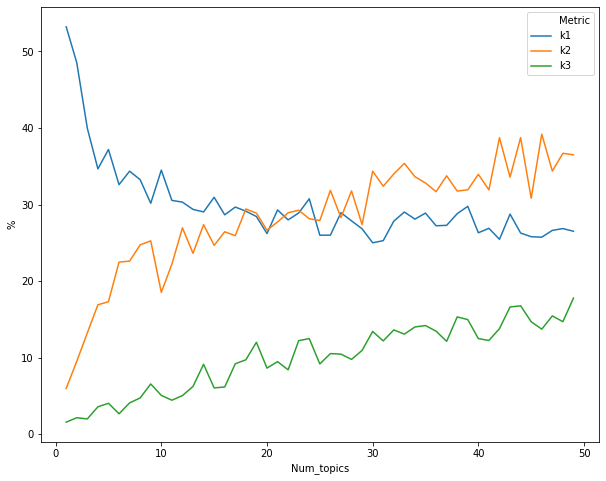

In [33]:
plt.figure(figsize = (10, 8), facecolor = None) 
ax = sns.lineplot(x='Num_topic', y='Result',hue='Metric', data=result)
plt.xlabel("Num_topics")
plt.ylabel("%")

### Project WICKET

Description of the commits we received from the github

In [ ]:
# Repo.clone_from('https://github.com/apache/wicket.git', 'Desktop/g')
# repo = git.Repo(r"C:\\Users\\User\\Desktop\\g\\.git")
# d = dict()
# for commit in repo.iter_commits():
#     d[commit.hexsha] = commit.message
# f = open(r"C:\\Users\\User\\Desktop\\commits_wicket.json", "w",encoding="utf8")
# json.dump(d, f)
# f.close()

In [7]:
path_commit_bug='WICKET/wicket_issues.json'
path_commit_function='WICKET/wicket_methods.json'
path_commit='WICKET/commits_wicket.json'

In [8]:
corpus,dictionary,df_function_description,df_commit_func_describe_bug,df_bug_desc,function_names=preprocessing(path_commit_bug,path_commit_function,path_commit,project='WICKET',verbose=True) 

Step 1. We need to open all paths and to load them to DataFrmame

File with commit/bug:


,Commit,Bug_number
0,36afc9550222996dfaac8441c2b9be723b59f2d3,0
1,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717
2,60cf70bb3194817237d2bb3eb12d93fdf1578f8c,0
3,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717
4,0ae05520a729b8462fcece990489105b81374629,0
5,95a90b49fa2a029e2d738f17cc6af18d26a41672,0
6,678ffebddcc1292abe63cd600990990e9e1eb0ba,0
7,4eb9b40fcb9d4c5e79d20cbf5082b19cc223616f,0
8,b41c6b8934607cf7f64c90a125cf746a11ab5eac,0
9,9c34185602c9aec3db7bcf8498ce85ac56b1043f,0



File with commit/functions:


,Commit,Function
0,bafda1afa582eb37430fe078c4e19d7cdc4bd7bb,wicket-util/src/test/java/org/apache/wicket/ut...
1,bafda1afa582eb37430fe078c4e19d7cdc4bd7bb,wicket-util/src/test/java/org/apache/wicket/ut...
2,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/main/java/org/apache/wicket/cdi...
3,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/main/java/org/apache/wicket/cdi...
4,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/test/java/org/apache/wicket/cdi...
5,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/test/java/org/apache/wicket/cdi...
6,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/test/java/org/apache/wicket/cdi...
7,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/test/java/org/apache/wicket/cdi...
8,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/test/java/org/apache/wicket/cdi...
9,f38d32e0d6ca18877ce41255a58b37ea4f6849d3,wicket-cdi/src/test/java/org/apache/wicket/cdi...



File with commit/describe:


,Commit,Describe
0,5168b792d2231826262b72c8bbc274880de878e4,WICKET-6797 Use space character as a separator...
1,0ddbc47ded4cf63634b474383b7f62b8bfb27a5e,[CI] Cache the Maven local repository for fast...
2,c67feb10c074a107019cea1f4f481daea2e51e63,WICKET-6796 Report the component path when fai...
3,96c99181ac74607910795eefbb27c88a706e8f0d,WICKET-6793 remove pending from map too\n
4,7da5fa9e48ecbc7dcc7a2cb6d7cbb98ad935185f,Trigger build for pull requests too\n\nhttps:/...
5,370d2ad1fdca4926f093b759f735a5c7741696ec,Remove the filter of branches on push\n
6,99cdfa5d6cd1f359c855af21595ca4aa5137b6e1,Merge pull request #437 from theigl/WICKET-679...
7,b8b6d20d66afc030cbd4ebbe7b454d358ddfae26,Update Jetty to 9.4.29\n
8,b18748355203b623fba496ae5c3211fd48bb4fc0,WICKET-6795 Avoid splitting and joining ajax e...
9,15c314692ce2abfd60e6f2f554339df97165f7a7,WICKET-6791 Offload WebSocket push when initia...



Step 2. Lets merge three dataframes in one


,Commit,Bug_number,Function,Describe
0,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,wicket-core/src/main/java/org/apache/wicket/aj...,[WICKET-6717] 'native' seems to be reserved wo...
1,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,wicket-core/src/main/java/org/apache/wicket/aj...,[WICKET-6717] 'native' seems to be reserved wo...
2,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,wicket-core/src/main/java/org/apache/wicket/ma...,[WICKET-6717] 'native' seems to be reserved wo...
3,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,wicket-core/src/main/java/org/apache/wicket/ma...,[WICKET-6717] 'native' seems to be reserved wo...
4,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,wicket-core/src/main/java/org/apache/wicket/ma...,[WICKET-6717] automatic module names are renam...
5,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,wicket-core/src/main/java/org/apache/wicket/ma...,[WICKET-6717] automatic module names are renam...
6,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,wicket-examples/src/main/java/org/apache/wicke...,[WICKET-6717] automatic module names are renam...
7,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,wicket-examples/src/main/java/org/apache/wicke...,[WICKET-6717] automatic module names are renam...
8,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,wicket-examples/src/main/java/org/apache/wicke...,[WICKET-6717] automatic module names are renam...
9,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,wicket-examples/src/main/java/org/apache/wicke...,[WICKET-6717] automatic module names are renam...



Step 3. Lets do small preprocessing to column "Function" and "Describe"


,Commit,Bug_number,Function,Describe
0,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...,[WICKET-6717] 'native' seems to be reserved word
1,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...,[WICKET-6717] 'native' seems to be reserved word
2,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,FormComponentUpdatingBehavior.getEvent(),[WICKET-6717] 'native' seems to be reserved word
3,cf41c1cad393c424c205d4b4c9c3336fa2a1e72b,6717,FormComponentUpdatingBehavior.getEvent(),[WICKET-6717] 'native' seems to be reserved word
4,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,SubresourceHeaderResponse.render(HeaderItem),[WICKET-6717] automatic module names are renam...
5,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,SubresourceHeaderResponse.SubresourceHeaderRes...,[WICKET-6717] automatic module names are renam...
6,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,IntegrityDemoPage.renderHead(IHeaderResponse),[WICKET-6717] automatic module names are renam...
7,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,SriApplication.init(),[WICKET-6717] automatic module names are renam...
8,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,SriApplication.getHomePage(),[WICKET-6717] automatic module names are renam...
9,a83f4a7daf5c33fa7bd91a811cf79e75da2aff45,6717,SriApplication.configure(ISubresourceHeaderItem),[WICKET-6717] automatic module names are renam...



Number of unique functions: 13225
Number of unique bugs: 1586

Step 4. Lets get a document describing each function


,Function,Decription
0,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...,WICKET-4686 MountMapper does not support corre...
1,FormComponentUpdatingBehavior.getEvent(),[WICKET-6717] 'native' seems to be reserved word
2,SubresourceHeaderResponse.render(HeaderItem),[WICKET-6717] automatic module names are renam...
3,SubresourceHeaderResponse.SubresourceHeaderRes...,[WICKET-6717] automatic module names are renam...
4,IntegrityDemoPage.renderHead(IHeaderResponse),[WICKET-6717] automatic module names are renam...
5,SriApplication.init(),[WICKET-6717] automatic module names are renam...
6,SriApplication.getHomePage(),[WICKET-6717] automatic module names are renam...
7,SriApplication.configure(ISubresourceHeaderItem),[WICKET-6717] automatic module names are renam...
8,ClientPropertiesTest.timezoneJsPositive(),Bump jackson-databind from 2.9.9 to 2.9.10.1 (...
9,FormComponent.getParameterValues(String),WICKET-6708 Made lowercase conversion local in...



Step 5. Lets do preprocessing for function description


,Function,Decription,Description_clear
0,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...,WICKET-4686 MountMapper does not support corre...,"[mount, mapper, support, correctly, parameter,..."
1,FormComponentUpdatingBehavior.getEvent(),[WICKET-6717] 'native' seems to be reserved word,"[native, seem, reserve, word]"
2,SubresourceHeaderResponse.render(HeaderItem),[WICKET-6717] automatic module names are renam...,"[automatic, module, name, rename, accord, java..."
3,SubresourceHeaderResponse.SubresourceHeaderRes...,[WICKET-6717] automatic module names are renam...,"[automatic, module, name, rename, accord, java..."
4,IntegrityDemoPage.renderHead(IHeaderResponse),[WICKET-6717] automatic module names are renam...,"[automatic, module, name, rename, accord, java..."
5,SriApplication.init(),[WICKET-6717] automatic module names are renam...,"[automatic, module, name, rename, accord, java..."
6,SriApplication.getHomePage(),[WICKET-6717] automatic module names are renam...,"[automatic, module, name, rename, accord, java..."
7,SriApplication.configure(ISubresourceHeaderItem),[WICKET-6717] automatic module names are renam...,"[automatic, module, name, rename, accord, java..."
8,ClientPropertiesTest.timezoneJsPositive(),Bump jackson-databind from 2.9.9 to 2.9.10.1 (...,"[bump, jackson, databind]"
9,FormComponent.getParameterValues(String),WICKET-6708 Made lowercase conversion local in...,"[make, lowercase, conversion, local, insentive..."


Our description is now ready for apply topic modelling

Step 6. We get a description of bugs directly from the site "Jira", so an internet connection is required
It takes time


,Bug,Description
0,6717,Automatic-Module-Name should be valid Java ide...
1,397,"Iv the DDChoice is empty at first, you get a ..."
2,6708,org.apache.wicket.markup.html.form.FormCompone...
3,387,"It has been broken since ""Support for serializ..."
4,6707,I am getting error: *Method [public boolean cz...
5,6704,* when trying to serialize my custom object wi...
6,6613,"Hi, \r\n\r\nI've recently upgraded my project ..."
7,6689,So ClientProperties.getTimeZone() got UTC offs...
8,6678,Calling cookieUtils.save(xxx) with log.isDebug...
9,6651,After upgrading from 8.3.0 to 8.4.0 redirectin...



Step 7. Do preprocessing for "Description"


,Bug,Description,Description_clear
0,6717,Automatic-Module-Name should be valid Java ide...,"[automatic, module, name, valid, java, identif..."
1,397,"Iv the DDChoice is empty at first, you get a ...","[iv, choice, empty, first, get, bitte, auswähl..."
2,6708,org.apache.wicket.markup.html.form.FormCompone...,"[org, apache, wicket, markup, html, form, form..."
3,387,"It has been broken since ""Support for serializ...","[it, break, since, support, serialize, nest, f..."
4,6707,I am getting error: *Method [public boolean cz...,"[get, error, method, public, boolean, cz, kb, ..."
5,6704,* when trying to serialize my custom object wi...,"[try, serialize, custom, object, non, serializ..."
6,6613,"Hi, \r\n\r\nI've recently upgraded my project ...","[hi, recently, upgrade, project, wicket, versi..."
7,6689,So ClientProperties.getTimeZone() got UTC offs...,"[so, client, properties, time, zone, get, offs..."
8,6678,Calling cookieUtils.save(xxx) with log.isDebug...,"[call, utils, save, xxx, log, debug, enable, t..."
9,6651,After upgrading from 8.3.0 to 8.4.0 redirectin...,"[after, upgrade, redirect, reset, response, ex..."



Step 8. Now we have prepared all data for applying topic modelling


In [9]:
topic_modeling(verbose=True)

Number of topics:15
Model:LDA 
Topics from function description


,Function,Description_clear,Function_topics
0,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...,"[mount, mapper, support, correctly, parameter,...","[(0, 0.086695954), (2, 0.045685146), (3, 0.047..."
1,FormComponentUpdatingBehavior.getEvent(),"[native, seem, reserve, word]","[(0, 0.022221714), (1, 0.022221714), (2, 0.022..."
2,SubresourceHeaderResponse.render(HeaderItem),"[automatic, module, name, rename, accord, java...","[(2, 0.118527904), (6, 0.6740592), (9, 0.11851..."
3,SubresourceHeaderResponse.SubresourceHeaderRes...,"[automatic, module, name, rename, accord, java...","[(2, 0.11852789), (6, 0.6740593), (9, 0.118515..."
4,IntegrityDemoPage.renderHead(IHeaderResponse),"[automatic, module, name, rename, accord, java...","[(2, 0.11852789), (6, 0.6740592), (9, 0.118515..."
5,SriApplication.init(),"[automatic, module, name, rename, accord, java...","[(2, 0.11852789), (6, 0.6740592), (9, 0.118515..."
6,SriApplication.getHomePage(),"[automatic, module, name, rename, accord, java...","[(2, 0.11852789), (6, 0.6740592), (9, 0.118515..."
7,SriApplication.configure(ISubresourceHeaderItem),"[automatic, module, name, rename, accord, java...","[(2, 0.11852789), (6, 0.6740593), (9, 0.118515..."
8,ClientPropertiesTest.timezoneJsPositive(),"[bump, jackson, databind]","[(0, 0.06666667), (1, 0.06666667), (2, 0.06666..."
9,FormComponent.getParameterValues(String),"[make, lowercase, conversion, local, insentive...","[(0, 0.41539076), (1, 0.09982638), (4, 0.29728..."



Topics words
(0, '0.069*"wicket" + 0.065*"link" + 0.064*"value" + 0.044*"date"')
(1, '0.258*"request" + 0.039*"web" + 0.037*"handler" + 0.034*"ajax"')
(2, '0.090*"java" + 0.075*"wicket" + 0.073*"diamonds" + 0.054*"bug"')
(3, '0.067*"page" + 0.061*"add" + 0.032*"application" + 0.031*"miss"')
(4, '0.107*"form" + 0.081*"ajax" + 0.048*"test" + 0.047*"fix"')
(5, '0.076*"resource" + 0.072*"add" + 0.047*"path" + 0.037*"exception"')
(6, '0.154*"fix" + 0.114*"wicket" + 0.073*"containers" + 0.050*"properly"')
(7, '0.112*"use" + 0.078*"instead" + 0.055*"type" + 0.052*"model"')
(8, '0.124*"file" + 0.073*"remove" + 0.062*"wicket" + 0.041*"upload"')
(9, '0.075*"wicket" + 0.061*"resource" + 0.052*"fail" + 0.046*"apache"')
(10, '0.239*"page" + 0.074*"encode" + 0.059*"parameters" + 0.054*"store"')
(11, '0.084*"change" + 0.075*"transparent" + 0.061*"markup" + 0.053*"ajax"')
(12, '0.074*"string" + 0.073*"fix" + 0.047*"http" + 0.044*"revert"')
(13, '0.173*"support" + 0.166*"mapper" + 0.165*"mount" + 0.15

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.298395 -0.316198       1        1  21.368816
9     -0.098852 -0.038881       2        1  10.944253
5      0.114149  0.055615       3        1   7.238237
0     -0.199202  0.009025       4        1   6.507945
11    -0.218078 -0.059563       5        1   6.281041
4     -0.108359 -0.056784       6        1   6.244502
7      0.062249  0.169534       7        1   5.248147
2     -0.056539  0.030870       8        1   5.041250
8     -0.096297  0.033658       9        1   4.971742
3      0.107102  0.210674      10        1   4.947317
10     0.195007  0.217785      11        1   4.875819
6     -0.136031 -0.097754      12        1   4.385520
12     0.059650 -0.140474      13        1   4.161701
1     -0.037515  0.044139      14        1   4.023405
14     0.114320 -0.061646      15        1   3.760304, topic_info=    Category         Freq            Term        Total  loglift  logprob
9    Default  4323.000000          mapper  4323.000000  30.0000  30.0000
10   Default  4292.000000           mount  4292.000000  29.0000  29.0000
21   Default  4551.000000         support  4551.000000  28.0000  28.0000
4    Default  4122.000000       correctly  4122.000000  27.0000  27.0000
13   Default  4104.000000       parameter  4104.000000  26.0000  26.0000
15   Default  4012.000000    placeholders  4012.000000  25.0000  25.0000
119  Default  1822.000000            page  1822.000000  24.0000  24.0000
56   Default  1486.000000         request  1486.000000  23.0000  23.0000
45   Default  1769.000000             fix  1769.000000  22.0000  22.0000
42   Default  3493.000000          wicket  3493.000000  21.0000  21.0000
7    Default  1501.000000            form  1501.000000  20.0000  20.0000
77   Default  1479.000000        resource  1479.000000  19.0000  19.0000
72   Default   752.000000            file   752.000000  18.0000  18.0000
60   Default  1252.000000             use  1252.000000  17.0000  17.0000
213  Default  1002.000000             add  1002.000000  16.0000  16.0000
0    Default  1836.000000            ajax  1836.000000  15.0000  15.0000
316  Default   641.000000          change   641.000000  14.0000  14.0000
27   Default   745.000000            java   745.000000  13.0000  13.0000
264  Default   727.000000           error   727.000000  12.0000  12.0000
366  Default   574.000000     transparent   574.000000  11.0000  11.0000
300  Default   565.000000         instead   565.000000  10.0000  10.0000
75   Default   759.000000             org   759.000000   9.0000   9.0000
73   Default   895.000000            find   895.000000   8.0000   8.0000
70   Default   808.000000            fail   808.000000   7.0000   7.0000
41   Default   983.000000            test   983.000000   6.0000   6.0000
116  Default   553.000000            link   553.000000   5.0000   5.0000
68   Default   617.000000          apache   617.000000   4.0000   4.0000
87   Default   449.000000        diamonds   449.000000   3.0000   3.0000
304  Default   498.000000          encode   498.000000   2.0000   2.0000
185  Default   441.000000          remove   441.000000   1.0000   1.0000
..       ...          ...             ...          ...      ...      ...
668  Topic15    80.972137           panel    82.047974   3.2675  -4.0352
902  Topic15    73.743935         convert    74.819771   3.2662  -4.1287
442  Topic15    63.644375           avoid    64.720207   3.2639  -4.2760
898  Topic15    60.912891          parser    61.988728   3.2632  -4.3198
62   Topic15    45.675774         element    46.751610   3.2574  -4.6077
965  Topic15    44.662983        overflow    45.738819   3.2569  -4.6301
816  Topic15    42.227791            char    43.303627   3.2555  -4.6862
549  Topic15    29.082434            when    30.158268   3.2443  -5.0591
797  Topic15    28.614838          binary    29.690676   3.2438  -5.0753
290  Topic15    27.590128            take    2

Topics from bugs description


,Bug_number,Topic
0,6717,"[(0, 0.03813458), (3, 0.034922022), (6, 0.1456..."
1,397,"[(2, 0.07111629), (6, 0.13776858), (7, 0.22129..."
2,6708,"[(0, 0.124152906), (1, 0.12633406), (2, 0.1115..."
3,387,"[(0, 0.12364531), (3, 0.07066716), (4, 0.28596..."
4,6707,"[(0, 0.046237294), (2, 0.14672516), (3, 0.0860..."
5,6704,"[(1, 0.0601718), (2, 0.0764667), (5, 0.3213274..."
6,6613,"[(0, 0.30749342), (3, 0.093691155), (4, 0.0848..."
7,6689,"[(3, 0.12099591), (4, 0.057419185), (5, 0.0388..."
8,6678,"[(0, 0.10774299), (2, 0.259795), (3, 0.0948499..."
9,6651,"[(0, 0.032056596), (1, 0.09261944), (2, 0.0659..."


Function recomendarion according to similarity
Example for bug 6717


,Fuction,Similarity
0,"AbstractResource.configureCache(WebRequest,Web...",0.954821
1,ComponentQueueingTest.queueNestedEnclosure(),0.950998
2,MarkupParser.initializeMarkupFilters(Markup),0.946651
3,PageWithLink.isBookmarkable(),0.946620
4,SharedResources.localeChange(),0.941763
5,"SharedResources.path(String,Locale,String)",0.941763
6,Component.detachBehaviors(),0.941746
7,PropertyResolver.getObjectWithGetAndSet(String...,0.937776
8,"DefaultPropertyLocator.get(Class,String)",0.937776
9,"PropertyResolver.get(Class,String)",0.937776


Actual functions for the same bug 6717


,Fuction
0,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...
1,AjaxFormChoiceComponentUpdatingBehavior.AjaxFo...
2,FormComponentUpdatingBehavior.getEvent()
3,FormComponentUpdatingBehavior.getEvent()
4,SubresourceHeaderResponse.render(HeaderItem)
5,SubresourceHeaderResponse.SubresourceHeaderRes...
6,IntegrityDemoPage.renderHead(IHeaderResponse)
7,SriApplication.init()
8,SriApplication.getHomePage()
9,SriApplication.configure(ISubresourceHeaderItem)



EVALUATION
Top K


,Bag,Top_k,Functions_in_bag,Count_all_functions,%
0,6717,4283,10,13225,32.385633
1,397,246,1,13225,1.860113
2,6708,4384,19,13225,33.149338
3,387,655,2,13225,4.952741
4,6707,4659,6,13225,35.228733
5,6704,9131,16,13225,69.043478
6,6613,11464,9,13225,86.684310
7,6689,2217,2,13225,16.763705
8,6678,25,4,13225,0.189036
9,6651,2515,2,13225,19.017013


Average Top K %: 36.66076277065156

Precision at K


,Bug,%,Functions_in_bug,Number_recomendations,Correctly_suggested
0,6717,0.000000,10,100,0
1,397,0.000000,1,100,0
2,6708,0.000000,19,100,0
3,387,0.000000,2,100,0
4,6707,0.000000,6,100,0
5,6704,0.000000,16,100,0
6,6613,0.000000,9,100,0
7,6689,0.000000,2,100,0
8,6678,100.000000,4,100,4
9,6651,0.000000,2,100,0


Average Precision at K %: 8.53026442396792

K3


,Bug,%,Functions_in_bug,Correctly_suggested
0,6717,0.000000,10,0
1,397,0.000000,1,0
2,6708,0.000000,19,0
3,387,0.000000,2,0
4,6707,0.000000,6,0
5,6704,0.000000,16,0
6,6613,0.000000,9,0
7,6689,0.000000,2,0
8,6678,0.000000,4,0
9,6651,0.000000,2,0


Average K3 %: 2.0361356546005163


(15, 36.66076277065156, 8.53026442396792, 2.0361356546005163)

### Parameter Search

In [11]:
list_topic=range(1,40,1)
num=[]
typ=[]
k=[]
for i in list_topic:
    res=topic_modeling(NUM_TOPICS=i)
    num.extend([res[0],res[0],res[0]])
    typ.extend(['k1','k2','k3'])
    k.extend([res[1],res[2],res[3]])
result=pd.DataFrame.from_dict({'Num_topic': num, 'Metric': typ,'Result': k})

In [12]:
result.head(20)

,Num_topic,Metric,Result
0,1,k1,55.881139
1,1,k2,1.458209
2,1,k3,0.215916
3,2,k1,49.446389
4,2,k2,1.784795
5,2,k3,0.243944
6,3,k1,43.953816
7,3,k2,2.949123
8,3,k3,0.337779
9,4,k1,41.645351


Text(0, 0.5, '%')

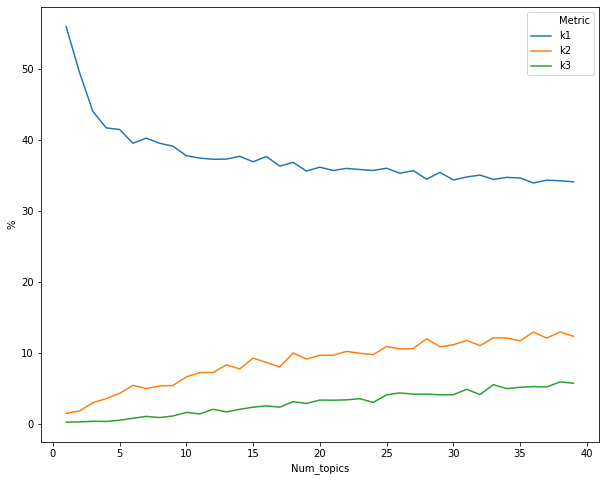

In [13]:
plt.figure(figsize = (10, 8), facecolor = None) 
ax = sns.lineplot(x='Num_topic', y='Result',hue='Metric', data=result)
plt.xlabel("Num_topics")
plt.ylabel("%")